# Step4 演習05 ロジスティック回帰からニューラルネットへ
---

Step4では手書き数字の認識(Optical Character Recognition; OCR)を実装します。

まずはロジスティック回帰で実装を行い、モデルやパラメータを変更することによってスコアへどのような影響があるか体験してもらいます。

今回はscikit-learnを利用して実装を行います。

OCRはマルチクラス分類問題ですが、scikit-learnの`LogisticRegression()`を使うとオプションなしで一対多分類器として動いてくれるため、とても簡単にOCRを実装できます。

次に、ニューラルネットワークでロジスティック回帰を実装します。

多層のニューラルネットワークへの学習（ディープラーニング）もパラメータを変えるだけで実現できるので、学習にかかる時間とスコアの違いを身をもって体感してください。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- scikit-learnを使ったニューラルネットワークの実装を行う。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scikit-learn](http://scikit-learn.org/stable/index.html) Pythonのオープンソース機械学習ライブラリの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## 今回使うデータに関して
数字OCRベンチマーク用サンプルデータとして、MNISTのデータが有名です。機械学習業界の"Hello, world!"ということができるでしょう。

「0」から「9」までの10種類の数字をこれから判別します。

In [3]:
num_labels = 10 #「0」から「9」の数字をこれから判別します。

## MNISTデータのロード
データをロードします。
mldata.orgからMNIST originalデータをダウンロードします。使用している回線によっては時間がかかる場合があります。

一度ダウンロードしたらキャッシュしますので、再度走らせるときはダウンロードの時間がかかりません。

In [4]:
mnist = datasets.fetch_mldata('MNIST original')

今回使用するMNISTの画像の枚数は70000枚、画像データのと特徴は28x28 = 784ピクセルです。

- 画像データの数：70000枚
- 画像データの特徴：28x28 = 784ピクセル

下のセルを実行することで画像データの数を** num_data **に、画像データの特徴を** input_layer_size  ** にそれぞれ格納します。


In [5]:
num_data, input_layer_size = mnist.data.shape #70000枚の28x28=784ピクセルの画像です

In [6]:
print("訓練データ数：{}".format(num_data))
print("訓練データの特徴の数：{}".format(input_layer_size))

訓練データ数：70000
訓練データの特徴の数：784


## データのシャッフル
MNIST originalデータをシャッフルしてその冒頭3000サンプルだけ訓練データとして利用することにします。

今回使用するMNISTデータのサンプル数は70000です。この全てを訓練データとして使ってしまうと、学習に使用しなかったデータに対しても正しく予測してくれるのか判断する方法がなくなってしまいます。試作段階では全てのデータを学習に用いてはいけません。（詳しくはStep5で学びます）

また今回10分の1未満のデータせセットしか学習に使わないのは別の理由もあります。マシンスペックの関係で、膨大なデータを用いると学習がなかなか終わらないためです。今回は3000サンプルのみを使用します。

ここで3000サンプルをピックアップする前にデータをシャッフルするのは何故でしょうか。例えば、データがラベル(y)に対してソートされていたとします。すると、そのまま冒頭3000サンプルを取ってしまうと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。ぱっと見で分からないような規則でソートされている可能性もあるので、一見バラバラに見えても必ず最初にシャッフルしましょう。

下のセルを実行すると3000サンプルをランダムにシャッフルしたデータを、** X ** と ** y ** にそれぞれ格納してくれます。

In [7]:
shuffle_idx = np.random.permutation(num_data)
X = mnist.data[shuffle_idx[:3000]]   # ランダム化された画像データ3000枚
y = mnist.target[shuffle_idx[:3000]] # 各画像（3000枚）に書かれている数字（「正しい答え」）

データのシャッフルはscikit-learnのtrain_test_splitを使うこともできます。これは訓練用のデータとテスト用のデータを分けてくれるので便利です。習熟したらscikit-learnチュートリアルを読んでこれを使いましょう。

参考：
[scikit-learnチュートリアル sklearn.cross_validation.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split)

訓練例の数(3000個)は`m`、特徴の数(784ピクセル)は`n`に格納します。

In [8]:
m, n = X.shape #訓練例の数はm, 特徴の数はn

In [9]:
print("訓練例の数：{}".format(m))
print("特徴の数：{}".format(n))

訓練例の数：3000
特徴の数：784


## データの視覚化
使用するデータの準備ができました。ここではランダムに並べた最初の画像を表示させてみます。

配列`X`には3000枚の画像データ(pixel)が、一列に並んで入っています。（`X`の`shape`は`(3000, 784)`）

この画像を表示させるには、一列に並んでしまっている`3000`枚の画像データをそれぞれ２次元`(28, 28)`に戻す必要があります。それには`reshape`を使います。

下の画像は一枚の数字データに対してreshapeを行なったイメージ図です。

<div align="center"  style="width:70%">
<img src="./dataStep4/img_reshape.png"></div>

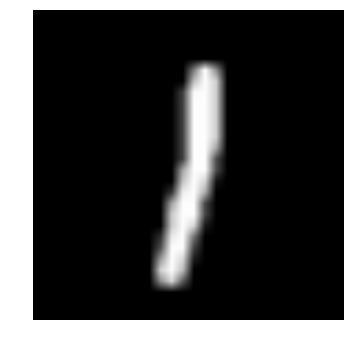

数字 1


In [10]:
X_reshaped = X.reshape((3000, 28, 28))

plt.imshow(X_reshaped[0,:,:])
plt.axis("off")
plt.gray()
plt.show()

print("数字 {0:1.0f}".format(y[0]))

一つだけでは見栄えがしないので、100個表示させるプログラムを関数（ `displayData(images)` ）として実装しておきましょう。

In [ ]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

これを使って、訓練データから冒頭100個選んで視覚化しましょう。多少表示に時間がかかります。

セルの左、In [何某]のところが＊になっているとき、そのセルは実行中です。

In [ ]:
displayData(X[:100, :])

---
## ニューラルネットワーク
さて、どんな解析関数（多項式で表せる関数）にもフィッティングできる多項式の仮説を用いたロジスティック回帰は、あまりに学習不良を起こしやすく、使い物にならないことが分かりました。では、つぎにニューラルネットワークを実装しましょう。

scikit-learnのニューラルネットワークのAPIを利用してみます。

参考：
[scikit-learnチュートリアル sklearn.neural_network.MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [ ]:
from sklearn.neural_network import MLPClassifier

### モデルを立てる
では、モデルを立てましょう。ラッパーを使っているおかげで、ロジスティック回帰の時と似た雰囲気で実装できます。

今回、隠れ層１層、そのユニット数は50個にしています。
訓練例はとりあえず1000個としましょう。

In [ ]:
X1_train = mnist.data[shuffle_idx[:1000]] #学習時間削減のため1000個だけ対象にする
y1_train = mnist.target[shuffle_idx[0:1000]]
X1_CV = mnist.data[shuffle_idx[1000:1500]]
y1_CV = mnist.target[shuffle_idx[1000:1500]]

In [ ]:
estimator_nn = MLPClassifier(hidden_layer_sizes=(50, ),max_iter=1000)

In [ ]:
estimator_nn.fit(X1_train, y1_train)
score_nn_train = estimator_nn.score(X1_train, y1_train)
score_nn_CV = estimator_nn.score(X1_CV, y1_CV)
print("学習スコアは",score_nn_train,"、交差検証スコアは",score_nn_CV)

ウェイト（パラメータ）の数がロジスティック回帰よりも増えているため、訓練例1000個ではロジスティック回帰よりも交差検証スコアも低いようです。

### 学習曲線をプロットする
**【課題６】** 同じモデルで、訓練例の数を変えるとどのようにスコアが変わるかプロットしてみよう。Step4_02の学習曲線を描画する関数をヒントにしよう。

In [ ]:
#Coursemale-02 Step4 QuestionNumber6 6845b2535ed5df4ec5c17decf3dce0d0
def learning_curve_plot(estimator, X, y, train_sizes):
###############ここを穴埋めしてください###############
    plt.figure()
    plt.title(u"学習曲線")
    plt.xlabel(u"訓練例の数")
    plt.ylabel(u"スコア")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, n_jobs=2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.ylim(ymax=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="学習スコア")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="交差検証スコア")
    plt.legend(loc="best")
    plt.show() 
 #############################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [ ]:
%%bash
./validation_client.py male-02 4 6 Step4_05.ipynb api.internal.zero2one.jp

In [ ]:
learning_curve_plot(estimator_nn, mnist.data[shuffle_idx[:]], mnist.target[shuffle_idx[:]], np.linspace(0.012, 0.21,5))

scikit-learnのニューラルネットワーク実装は今のところCPUのみを用いた学習しか対応していません。これはCPUによる実装としては非常に高速ですが、一般には、GPUなどのコプロセッサーが活用され、大規模な学習が行われています。

### （発展）層を深くする（ディープラーニング）
層を深くするとどうなるだろうか。ユニット数を増やすとどうなるだろうか。とても時間がかかるので、寝ている間など、コンピューターを使わない時間帯に学習してスコアを計算するプログラムを走らせておこう。

## おわりに
今回の演習は盛りだくさんであるため、これでおしまいとします。Step8の演習ではニューラルネットワークをライブラリを使うだけではなく、自前でも実装します。自前での実装はモデル全体を把握し適切な実装を行う必要があり大変ですが、大変重要な練習です。また、Scikit-learnのパラメータを変化させながら実装し結果を確認することや自前で実装したニューラルネットワークとの違いを比較・検討することで、それが何を意味するのか考えていく練習も、貴重な時間を有意義に過ごせるでしょう。